# Download Zip Files

## Packages & Directories

In [1]:
import os
import pandas as pd
import geopandas as gpd

DIRECTORY = r'C:\Users\nelms\Documents\Penn\MUSA-650\FinalProject'
DIR = DIRECTORY
PROJ_DIR = DIR
DATA_DIR = os.path.join(PROJ_DIR, 'data')
ZIP_DIR = os.path.join(DATA_DIR, 'raw', 'NAIP')
%cd {PROJ_DIR}

tiff_proj = 'EPSG:26910'

C:\Users\nelms\Documents\Penn\MUSA-650\FinalProject


In [2]:
# REFERENCE DATA
CAPSTONE_DATA_FOLDER = r'C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics\data'
#META_FOLDER = CAPSTONE_DATA_FOLDER + r'\meta'
#RAW_FOLDER = CAPSTONE_DATA_FOLDER + r'\raw'
CAPSTONE_CLEAN_FOLDER = CAPSTONE_DATA_FOLDER + r'\clean'

project_crs = 'EPSG:7132'

path = CAPSTONE_CLEAN_FOLDER + r'\sf_2010censusblock.geojson'
sfblock = gpd.read_file(path).to_crs(project_crs)

sftract = sfblock.dissolve(by='geoid10').reset_index(drop=False).drop('block_id', 1)

sf_landform = sfblock.unary_union
sf_landform = gpd.GeoDataFrame(geometry=[sf_landform], crs=project_crs).to_crs(tiff_proj)

C:\Users\nelms\AppData\Local\Temp\ipykernel_12948\3572012745.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  sftract = sfblock.dissolve(by='geoid10').reset_index(drop=False).drop('block_id', 1)


## Extract Zips

### Locate Zips

In [3]:
zip_locations = [(root,dirnames,filenames) for root,dirnames,filenames in os.walk(ZIP_DIR)][0][2]
zip_locations[0:5]

['m_3712212_se_10_060_20180804.ZIP',
 'm_3712212_se_10_060_20200524.ZIP',
 'm_3712212_se_10_1_20100611.ZIP',
 'm_3712212_se_10_1_20120520.ZIP',
 'm_3712212_se_10_1_20140613.ZIP']

### Downloading Zip as Temporary Bytes file

In [4]:
from skimage.io import imread, imshow
import rasterio as rio

from io import BytesIO
from zipfile import ZipFile
import numpy as np

In [5]:
from tqdm import tqdm

# PIXEL SIZE
def spatial_resolution(raster):
    """extracts the XY Pixel Size"""
    t = raster.transform
    x = t[0]
    y =-t[4]
    return x, y

# CONVERT IMAGE TO RASTER.IO
def get_raster_info(landsat):
    #landsat = rio.open(file_path)
    meta = landsat.meta # dict of meata
    proj = meta['crs'].data['init'] # get proj string
    bounds = [  # Set the extent of the images
        landsat.bounds.left,
        landsat.bounds.right,
        landsat.bounds.bottom,
        landsat.bounds.top,
    ]
    bands = landsat.indexes # band amount & count
    shape = landsat.shape   # shape of raster
    resolution = spatial_resolution(landsat) # pixel size
    transform = landsat.transform
    landsat = landsat.read()
    
    return [landsat, transform, proj, bounds, bands, shape, resolution, meta]

# OPEN ZIPS, CONVERT IMAGES TO RASTER, AND STORE RASTERS IN A DATAFRAME
img_list = []
image_types = ['.tif'] #['.jpg', '.png', '.tif']
# loop through each zip location
for zip_path in tqdm(zip_locations):
    # full zip path
    full_zip_path = os.path.join(ZIP_DIR, zip_path)
    # open zip
    with ZipFile(full_zip_path, mode="r") as zip_contents:
        # list of zip contents
        for entry in zip_contents.infolist():
            # only look if an image
            ## specifically .tif
            if any(img for img in image_types if img in entry.filename):
                # open image
                with zip_contents.open(entry) as file:
                    # open as rasterio dataset
                    with rio.open(file) as dataset:
                        # make list/row with name, raster dataset, & info
                        file_list = [entry.filename] + get_raster_info(dataset)
                        img_list.append(file_list)
# convert lists to dataframe
cols = ['filename', 'raster', 'transform', 'proj', 'bounds', 'bands', 'shape', 'resolution', 'meta']
img_df = pd.DataFrame(img_list, columns=cols)

 ... (more hidden) ...


## Raster Dataframe

### Dates

In [6]:
# DATES
# get date of each image
img_df['date'] = img_df['filename'].str.split('_').apply(lambda dt: dt[-1].split('.')[0])
img_df['date'] = pd.to_datetime(img_df['date'])
# year
img_df['year'] = img_df['date'].dt.year
img_df.head()

,filename,raster,transform,proj,bounds,bands,shape,resolution,meta,date,year
0,m_3712212_se_10_060_20180804.tif,"[[[42, 40, 38, 39, 43, 49, 42, 67, 94, 108, 84...","(0.6, 0.0, 538356.0, 0.0, -0.6, 4185282.0, 0.0...",epsg:26910,"[538356.0, 544200.0, 4178016.0, 4185282.0]","(1, 2, 3, 4)","(12110, 9740)","(0.6, 0.6)","{'driver': 'GTiff', 'dtype': 'uint8', 'nodata'...",2018-08-04,2018
1,m_3712212_se_10_060_20200524.tif,"[[[176, 181, 128, 129, 122, 134, 113, 75, 65, ...","(0.6, 0.0, 538308.0, 0.0, -0.6, 4185330.0, 0.0...",epsg:26910,"[538308.0, 544248.0, 4177968.0, 4185330.0]","(1, 2, 3, 4)","(12270, 9900)","(0.6, 0.6)","{'driver': 'GTiff', 'dtype': 'uint8', 'nodata'...",2020-05-24,2020
2,m_3712212_se_10_1_20100611.tif,"[[[109, 194, 122, 106, 99, 125, 141, 152, 212,...","(1.0, 0.0, 538208.0, 0.0, -1.0, 4185430.0, 0.0...",epsg:26910,"[538208.0, 544349.0, 4177865.0, 4185430.0]","(1, 2, 3, 4)","(7565, 6141)","(1.0, 1.0)","{'driver': 'GTiff', 'dtype': 'uint8', 'nodata'...",2010-06-11,2010
3,m_3712212_se_10_1_20120520.tif,"[[[23, 25, 22, 21, 21, 23, 27, 28, 28, 37, 36,...","(1.0, 0.0, 538190.0, 0.0, -1.0, 4185440.0, 0.0...",epsg:26910,"[538190.0, 544360.0, 4177850.0, 4185440.0]","(1, 2, 3, 4)","(7590, 6170)","(1.0, 1.0)","{'driver': 'GTiff', 'dtype': 'uint8', 'nodata'...",2012-05-20,2012
4,m_3712212_se_10_1_20140613.tif,"[[[112, 131, 123, 72, 47, 102, 126, 121, 111, ...","(1.0, 0.0, 538209.0, 0.0, -1.0, 4185430.0, 0.0...",epsg:26910,"[538209.0, 544349.0, 4177866.0, 4185430.0]","(1, 2, 3, 4)","(7564, 6140)","(1.0, 1.0)","{'driver': 'GTiff', 'dtype': 'uint8', 'nodata'...",2014-06-13,2014


### Boundary Box

In [7]:
# GET POLYGON BOUNDARY BOX
from shapely.geometry import box
# bounds to box 
def bound_to_poly(b_list):
    #ymin, ymax, xmin, xmax = b_list
    left, right, bottom, top = b_list
    width = right-left
    height = top-bottom
    b_list = [
        left,
        top,
        width,
        height
    ]
    return box(b_list[0], b_list[1], b_list[0] + b_list[2], b_list[1] - b_list[3]) #Polygon(zip(b_list))
tiff_proj = img_df['proj'].values[0]
img_df['bgeom'] = img_df['bounds'].apply(bound_to_poly)
img_gdf = gpd.GeoDataFrame(img_df, crs=tiff_proj, geometry = img_df['bgeom'])

In [8]:
from shapely.ops import unary_union
y_gdf = img_df.groupby('year').agg({
    'bgeom':unary_union, 'resolution':'first', 'bands':'first', 'filename':'count', 'date':'first'
})
y_gdf = gpd.GeoDataFrame(y_gdf, crs=tiff_proj, geometry = y_gdf['bgeom']) \
    .drop(columns='bgeom')

### Find Year Intersections

In [9]:
# get overlapping counts
## from stack overflow
## https://gis.stackexchange.com/questions/387773/count-overlapping-features-using-geopandas
def count_overlapping_features(in_gdf):
    import shapely
    # Get the name of the column containing the geometries
    geom_col = in_gdf.geometry.name
    
    # Setting up a single piece that will be split later
    input_parts = [in_gdf.unary_union.buffer(0)]
    
    # Finding all the "cutting" boundaries. Note: if the input GDF has 
    # MultiPolygons, it will treat each of the geometry's parts as individual
    # pieces.
    cutting_boundaries = []
    for i, row in in_gdf.iterrows():
        this_row_geom = row[geom_col]
        this_row_boundary = this_row_geom.boundary
        if this_row_boundary.type[:len('multi')].lower() == 'multi':
            cutting_boundaries = cutting_boundaries + list(this_row_boundary.geoms)
        else:
            cutting_boundaries.append(this_row_boundary)
    
    
    # Split the big input geometry using each and every cutting boundary
    for boundary in cutting_boundaries:
        splitting_results = []
        for j,part in enumerate(input_parts):
            new_parts = list(shapely.ops.split(part, boundary).geoms)
            splitting_results = splitting_results + new_parts
        input_parts = splitting_results
    
    # After generating all of the split pieces, create a new GeoDataFrame
    new_gdf = gpd.GeoDataFrame({'id':range(len(splitting_results)),
                                geom_col:splitting_results,
                                },
                               crs=in_gdf.crs,
                               geometry=geom_col)
    
    # Find the new centroids.
    new_gdf['geom_centroid'] = new_gdf.centroid
    
    # Starting the count at zero
    new_gdf['count_intersections'] = 0
    
    # For each of the `new_gdf`'s rows, find how many overlapping features 
    # there are from the input GDF.
    for i,row in new_gdf.iterrows():
        new_gdf.loc[i,'count_intersections'] = in_gdf.intersects(row['geom_centroid']).astype(int).sum()
        pass
    
    # Dropping the column containing the centroids
    new_gdf = new_gdf.drop(columns=['geom_centroid'])[['id','count_intersections',geom_col]]
    
    return new_gdf

intersect_gdf = count_overlapping_features(y_gdf[y_gdf.index>=2016])
intersect_gdf

# PLOT
img_gdf = gpd.GeoDataFrame(img_df, crs=img_df['proj'].values[0], geometry = img_df['bgeom'])
#ax = img_gdf.plot(alpha=.5, column='year', ec='black', lw=2, legend=True)
ax = intersect_gdf.plot(column='count_intersections', ec='black', lw=2, legend=True)
sf_landform.plot(ax=ax, zorder=8, color='None')

,id,count_intersections,geometry
0,0,3,"POLYGON ((538308.000 4177968.000, 538308.000 4..."
1,1,3,"POLYGON ((538386.000 4171080.000, 538386.000 4..."


### Plot Raster Arrays by Year

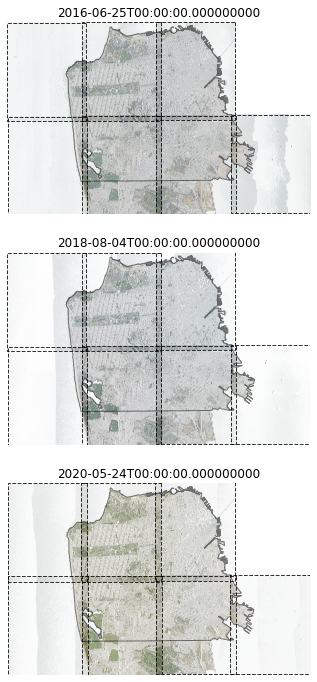

In [13]:
from rasterio.plot import show

years = [y for y in y_gdf.index if y >= 2016]

import matplotlib.pyplot as plt
cols, rows = 1, len(years)
axes = []
[[axes.append((c,r)) for r in range(rows)] for c  in range(cols)]
axis_count = len(axes)
fig, ax = plt.subplots(rows, cols, figsize=[18,12])

for row, year in enumerate(years):
    rast_trans = img_df.loc[img_df['year']==year][['raster','transform']].values
    for dataset, transform in rast_trans:
        #show(dataset, transform=transform, ax=ax[row, 0], cmap='gray')
        show(dataset, transform=transform, ax=ax[row])
    year_gdf = img_gdf[img_gdf['year']==year]
    for col in range(cols):
        axis = ax[row] #ax[row, col]
        year_gdf.plot(ax=axis, facecolor="none", edgecolor="black", alpha=.8, zorder=7, ls=('dashed'))
        sf_landform.plot(ax=axis, facecolor="none", edgecolor="black", alpha=.5, zorder=6)
        axis.set_title(img_df.loc[img_df['year']==year, 'date'].values[0])
        axis.set_axis_off()

## Import OSMnx

In [20]:
import osmnx as ox

sf_g = ox.graph_from_place("San Francisco, CA", network_type='drive')
sf_g = ox.project_graph(sf_g, to_crs=tiff_proj)

C:\ProgramData\Miniconda3\envs\MUSA-650\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [22]:
nodes_gdf, edges_gdf = ox.graph_to_gdfs(
        sf_g,
        nodes=True, edges=True,
        node_geometry=True,
        fill_edge_geometry=True)
edges_gdf = gpd.overlay(edges_gdf, y_gdf[['geometry']], how='intersection')

tun_filt = (edges_gdf['tunnel'].isna())
edges_gdf = edges_gdf[~tun_filt]

In [31]:
remove_hwy = ['unclassified', 'motorway_link', 'primary_link']
list_filt = edges_gdf['highway'].apply(type) == list
def remove_lists(hlist, remove_list = remove_hwy):
    filt_list = [h for h in hlist if h not in remove_list]
    if len(filt_list) == 0:
        filt_list = hlist
    return file_list[0]
edges_gdf.loc[list_filt, 'highway'] = edges_gdf.loc[list_filt, 'highway'].apply(remove_lists)
#

In [46]:
hwy_filt = (edges_gdf['highway'].str.contains('motorway'))
edges_gdf['hwy'] = False
edges_gdf.loc[hwy_filt, 'hwy'] = True
edges_gdf.loc[edges_gdf['bridge']=='yes', 'bridge'] = True
br_list_filt = edges_gdf['bridge'].apply(type) == list
edges_gdf.loc[br_list_filt, 'bridge'] = True
edges_gdf.loc[edges_gdf['bridge']=='movable', 'bridge'] = True

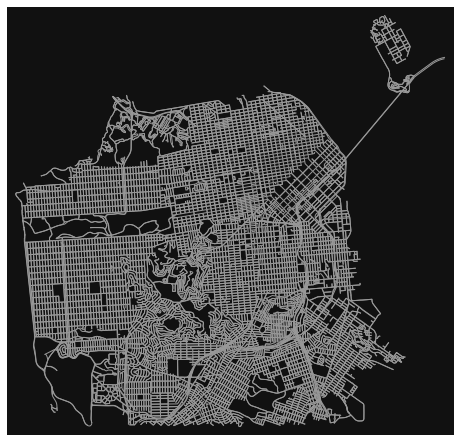

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [21]:
ox.plot_graph(sf_g, node_size=0)

## Cut

In [81]:
focus_df = img_df[img_df['year']==2018]
focus_array = focus_df['raster'].values[2]
focus_array = focus_array.transpose([1,2,0])
focus_array.shape

(12120, 9750, 4)

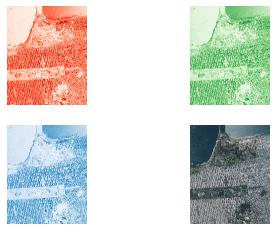

In [79]:
fig, ax = plt.subplots(2, 2)
ax[0,0].imshow(focus_array[:,:,0], cmap ='Reds')
ax[0,1].imshow(focus_array[:,:,1], cmap ='Greens')
ax[1,0].imshow(focus_array[:,:,2], cmap ='Blues')
ax[1,1].imshow(focus_array[:,:,:3])
for col in range(2):
    for row in range(2):
        ax[row, col].set_axis_off()

In [72]:
rgb_test = [
    [
        ['0r','1r','2r'],
        ['3r', '4r', '5r'],
        ['6r', '7r', '8r'],
        ['9r', '10r', '11r']
    ], #r
    [        
        ['0g','1g','2g'],
        ['3g', '4g', '5g'],
        ['6g', '7g', '8g'],
        ['9g', '10g', '11g']
        ], #g
    [
        ['0b', '1b', '2b'],
        ['3b', '4b', '5b'],
        ['6b', '7b', '8b'],
        ['9b', '10b', '11b']
    ]  #b
]
rgb_test = np.array(rgb_test)
rgb_test.transpose([1,2,0])[:,:,0]

array([['0r', '1r', '2r'],
       ['3r', '4r', '5r'],
       ['6r', '7r', '8r'],
       ['9r', '10r', '11r']], dtype='<U3')

In [135]:
focus_tensor = focus_array.transpose([2,0,1])

def cutting(x, y, bands = 4, shape=(80,80)):
    cwidth, cheight = shape
    area_study = np.arange(bands*cwidth*cheight).reshape(bands, cwidth, cheight)
    for i in range(cwidth):
        for j in range(cheight):
            for band in range(bands):
                area_study[band][i][j] = focus_tensor[band][y+i][x+j]
    area_study = area_study.reshape([-1, bands, cwidth, cheight])
    area_study = area_study.transpose([0,2,3,1])
    #area_study = area_study / 255
    return area_study

n_spectrum = 3
width = focus_tensor.shape[1]
height = focus_tensor.shape[2]

cut_shape = (64,64)
cwidth,cheight = cut_shape

wstep = int(width/cwidth)
hstep = int(height/cheight)
areas = []
for y in range(int((height-(cheight-hstep))/hstep)):
    for x in range(int((width-(cwidth-wstep))/wstep)):
        area = cutting(x*wstep, y*hstep, shape=cut_shape)
        areas.append(area)


IndexError: index 9828 is out of bounds for axis 0 with size 9750

In [131]:
# cut by using hsteps & wsteps to determine slices 
# reshape to (width,height, rgbi)

# 100ft x 100ft ~ 64 x 64
# 200ft x 200ft ~ 128 x 128
#

# run mask over images to determine if road
# remove bridge & highway

152

In [ ]:
## Create a binary mask from a given polygon
def polyToMask(imgSize, polygons):
    labelMask = np.zeros(imgSize, np.uint8)
    if not polygons:
        print('    EMPTY poly object')
        return labelMask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
    cv2.fillPoly(labelMask, exteriors, 1)
    cv2.fillPoly(labelMask, interiors, 0)
    return labelMask

## Create Sub Folders

In [ ]:
image_types = ['.jpg', '.png', '.tif']
folders = [
           fname for fname in zipfile.namelist() if 
           #not any(ftype for ftype in image_types if ftype in fname)
           '.' not in fname
           ]
replacing = {
    'ds/images/remote_sensing/otherDatasets/sentinel_2':'',
    'tif':'MS'
}
#replacing = {
#    '2750':'RGB'
#}

def replace_list_dict(flist, sdict):
  for good,bad in sdict.items():
    flist = [f.replace(good,bad).strip('/') for f in flist]
  return flist

folders = replace_list_dict(folders, replacing)

os.chdir(PROJ_DIR)
print(os.getcwd())

def create_path(NEW_DIR, BASE_DIR=PROJ_DIR):
  os.chdir(BASE_DIR)
  if os.path.exists(NEW_DIR) == False:
    os.mkdir(NEW_DIR)

for folder in folders:
  create_path(folder) 
  print(folder)

/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat
MS
MS/PermanentCrop
MS/Industrial
MS/Highway
MS/HerbaceousVegetation
MS/Forest
MS/AnnualCrop
MS/Pasture
MS/Residential
MS/SeaLake
MS/River


## Prepare Files as Dict

In [ ]:
from tqdm import tqdm

def split_path_name(full_filename):
  filepath, filename = full_filename.rsplit('/', 1)
  return filepath, filename

replacing = {
    'ds/images/remote_sensing/otherDatasets/sentinel_2':'',
    'tif/':'MS/'
}
#replacing = {
#    '2750/':'RGB/'
#}


def replace_dict(rstr, sdict):
  for good,bad in sdict.items():
    rstr = rstr.strip('/').replace(good,bad)
  return rstr

def replace_list_dict(flist, sdict):
  for good,bad in sdict.items():
    flist = [f.strip('/').replace(good,bad) for f in flist]
  return flist



zip_info = zipfile.infolist()
#zip_info = zip_info[500:505]

zip_names = {}
for zfile in zip_info:
    full_filename = zfile.filename

    if '.' in full_filename:
        
      full_filename = replace_dict(full_filename, replacing)

      parts = full_filename.split('/')
      if '_' in parts[0]:
        new_sub = parts[0].split('_')[0]
        full_filename = new_sub + '/' + full_filename
        print(full_filename)
      fpath, fname = split_path_name(full_filename)
      if os.path.isfile(os.path.join(fpath,fname)) == False:
        if fpath not in zip_names.keys():
          zip_names[fpath] = []
        zfile.filename = fname
        zip_names[fpath].append({
              'name': fname,
              'path': fpath,
              'file': zfile
              })

## Upload Files by Subfolder

In [ ]:

os.chdir(PROJ_DIR)
%cd {PROJ_DIR}
errors = []
tried=[]

for dirname, filelist in zip_names.items():
  UPLOAD_DIR = os.path.join(PROJ_DIR, dirname)
  os.chdir(UPLOAD_DIR)
  %cd {UPLOAD_DIR}
  for fdict in tqdm(filelist, desc='{} '.format(dirname)):
    fname, fpath, zfile = fdict['name'], fdict['path'], fdict['file']
    try:
      
      zipfile.extract(zfile)
      #tried.append(UPLOAD_DIR+'/'+fname)
    except:
      errors.append(fname, UPLOAD_DIR)

/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat
/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat


MS/Pasture : 100%|██████████| 23/23 [00:00<00:00, 93.96it/s] 


/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat


MS/Residential : 100%|██████████| 3000/3000 [00:29<00:00, 102.74it/s]


/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat


MS/SeaLake : 100%|██████████| 3000/3000 [00:29<00:00, 102.80it/s]


/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat


MS/River : 100%|██████████| 2500/2500 [00:25<00:00, 99.71it/s]


In [ ]:
tried

['/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1122.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1685.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1654.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_381.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_426.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_854.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_76.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1592.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1235.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_1770.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_970.tif',
 '/content/drive/MyDrive/Penn/MUSA-650/HW4/eurosat/MS/Pasture/Pasture_502.tif',
 '/content/drive/MyDrive/Penn/MUSA-

## UPLOAD TO GOOGLE DRIVE

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()
drive = GoogleDrive(gauth)

# To create a new folder
folder_name = input("Name the Folder : ")
folder = drive.CreateFile({'title' : folder_name, 'mimeType' : 'application/vnd.google-apps.folder'})
folder.Upload()

Name the Folder : dog_test


InvalidConfigError: ignored